In [2]:
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import Point, LineString

In [3]:
# data_frames = []

# for i in range(1, 16):
#     file_name = f"../res/result{i}.csv"
#     df = pd.read_csv(file_name)
#     data_frames.append(df)

# # 使用 concat 函数将所有 DataFrame 合并为一个
# result = pd.concat(data_frames)

# result.to_csv("../res/sample_taxi_region.csv")
df_order = pd.read_csv("../res/sample_taxi_region.csv")

In [4]:
# 按照出租车编号对数据进行分组
df_grouped = df_order.groupby('taxi_id')

In [16]:
# from datetime import datetime
# # 定义一个将时间字符串转换为datetime类型的函数
# def convert_time(time_string):
#     return datetime.strptime(time_string, '%H:%M:%S')

# # 使用apply行向量函数将整个时间列转换为datetime类型
# df_grouped['time'] = df_grouped['time'].apply(lambda x: convert_time(x))
# print(df_grouped.head(1000))
print(type(df_grouped))
df_grouped_slice = df_grouped.head(1000)
print(type(df_grouped_slice))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>
<class 'pandas.core.frame.DataFrame'>


In [18]:
# 分别处理每个出租车的订单
orders = []
df_sorted = df_grouped.apply(lambda x: x.sort_values('time'))
order_started = False
order_start_lat = None
order_start_lon = None
order_end_lat = None
order_end_lon = None
order_start_district = None
order_start_block = None
order_end_district = None
order_end_block = None
for _, row in df_sorted.iterrows():
    if row['is_passenger'] == 1 and not order_started:
        # 如果订单开始，记录起始点位置和时间
        order_start_lat = row['lat']
        order_start_lon = row['lon']
        order_start_time = row['time']
        order_start_district = row['region']
        order_start_block = row['block_id']
        order_started = True
    elif row['is_passenger'] == 0 and order_started:
        # 如果订单结束，记录终点位置，添加订单记录
        order_end_lat = row['lat']
        order_end_lon = row['lon']
        order_end_time = row['time']
        order_end_district = row['region']
        order_end_block = row['block_id']
        orders.append((row['taxi_id'], order_start_lat, order_start_lon, order_end_lat, order_end_lon, order_start_time, order_end_time, order_start_district, order_start_block, order_end_district, order_end_block))
        order_started = False

In [20]:
# 将订单记录整合到DataFrame中
orders_df = pd.DataFrame(orders, columns=['taxi_id', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'start_time', 'end_time', 'start_district', 'start_block', 'end_district', 'end_block'])
orders_df.to_csv('../res/orders.csv', index=False)

In [3]:
# 各区街道出发、到达数量统计
df_orders = pd.read_csv('../res/orders.csv')

# 将街区列和区列合并为一个属性列district_block
df_orders['from_district_block'] = df_orders['start_district'] + '-' + df_orders['start_block'].astype(str)
df_orders['to_district_block'] = df_orders['end_district'] + '-' + df_orders['end_block'].astype(str)

# 根据district_block进行分组，统计每个区块的订单数量
from_district_block = df_orders.groupby('from_district_block')['taxi_id'].count().sort_values(ascending=False)
to_district_block = df_orders.groupby('to_district_block')['taxi_id'].count().sort_values(ascending=False)

print(from_district_block)
print(to_district_block)

from_district_block
福田区-2      8441
福田区-3      5721
龙华区-71     4570
罗湖区-19     4398
龙岗区-51     4101
           ... 
龙岗区2-74       2
龙岗区-11        1
坪山区--1        1
南山区-1         1
龙岗区2-73       1
Name: taxi_id, Length: 94, dtype: int64
to_district_block
福田区-2     8352
福田区-3     5389
龙华区-71    4627
龙岗区-51    3948
宝安区-40    3879
          ... 
龙岗区-12       1
坪山区-46       1
光明区-35       1
龙华区-38       1
光明区-34       1
Name: taxi_id, Length: 100, dtype: int64


In [4]:
# 从各区到各区的概率
cross_tab = pd.crosstab(df_orders['start_district'], df_orders['end_district'], normalize='index')
print(cross_tab)

end_district         光明区       南山区       坪山区       宝安区       盐田区       福田区  \
start_district                                                               
光明区             0.528090  0.022472  0.000000  0.314607  0.000000  0.011236   
南山区             0.000963  0.728957  0.000170  0.087232  0.001246  0.126487   
坪山区             0.000000  0.016393  0.409836  0.000000  0.000000  0.000000   
宝安区             0.005139  0.123955  0.000087  0.770122  0.000958  0.053746   
盐田区             0.001739  0.010435  0.000000  0.022609  0.460870  0.109565   
福田区             0.000207  0.075002  0.000089  0.021336  0.003310  0.692781   
罗湖区             0.000144  0.024374  0.000096  0.013169  0.010822  0.240387   
龙华区             0.002390  0.028492  0.000191  0.020748  0.000861  0.071039   
龙岗区             0.000139  0.007041  0.004740  0.008574  0.001464  0.044197   
龙岗区2            0.000000  0.000000  0.333333  0.000000  0.333333  0.000000   

end_district         罗湖区       龙华区       龙岗区      龙岗区2  
start_

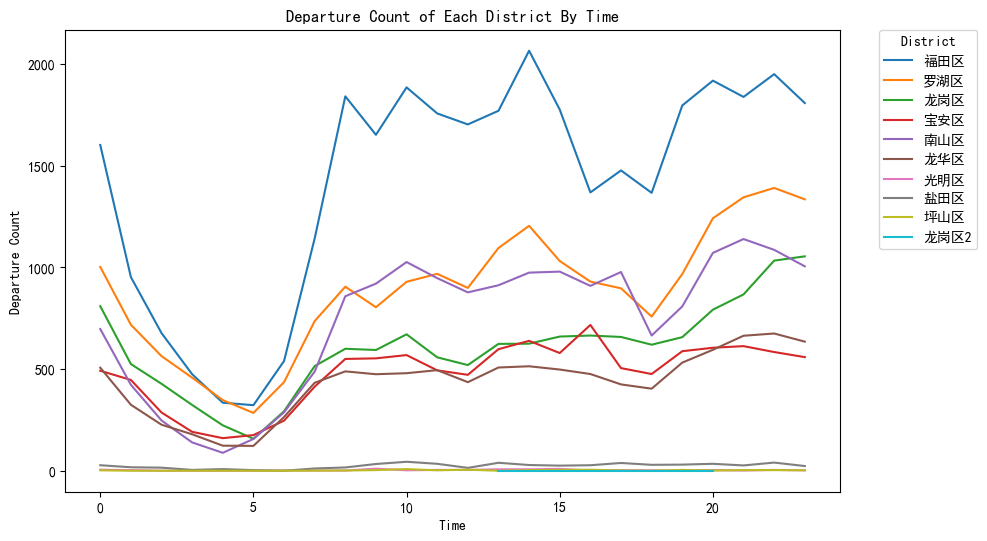

In [6]:
# 各区出发、到达的时间分布
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei']

# 将出发时间列转化为时间类型
df_orders['start_time'] = pd.to_datetime(df_orders['start_time'])
df_orders['end_time'] = pd.to_datetime(df_orders['end_time'])

# 按照区域和出发时间分组，计算每个小时的订单数量
grouped_start = df_orders.groupby(['start_district', df_orders['start_time'].dt.hour])['taxi_id'].count()
grouped_end = df_orders.groupby(['end_district', df_orders['end_time'].dt.hour])['taxi_id'].count()

# 将分组结果转为DataFrame，并将索引转为列
df_line_start = pd.DataFrame(grouped_start).reset_index()
df_line_end = pd.DataFrame(grouped_end).reset_index()

# 获取所有区域列表
districts = df_orders['start_district'].dropna().unique()

# 绘制所有区域的订单数量随时间的折线图
fig, ax = plt.subplots(figsize=(10, 6))

for district in districts:
    # 筛选出当前区域的数据
    data = df_line_start[df_line_start['start_district'] == district]
    # 绘制折线图
    ax.plot(data['start_time'], data['taxi_id'], label=district)

# 设置坐标轴标签和标题
ax.set_xlabel('Time')
ax.set_ylabel('Departure Count')
ax.set_title('Departure Count of Each District By Time')

# 添加图例
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='District')

plt.show()